In [ ]:
#RNN 망을 이용해서 마지막글자를 예측하는것
    #텍스트는 일단 embadding해주어야 한다./onehotencoding
    #multirnncell : rnn망의 레이어를 구축
    #지도학습 문제로 풀어서 앞의 3글자는 글자를 학습하고 뒤의 한글자는 target으로 예측하도록 학습하였다.
    
#문자인 경우 모든 문서에있는 단어와 취합된다. 모든문자를 인덱싱->숫자로 변경
    #정밀한 rnn을 위해서 layer를 줘서(이용해서) 학습한다. (여러층 쌓는게 가능하다.)

In [28]:
from tensorflow.python.framework import ops
ops.reset_default_graph() #그래프 초기화
import tensorflow as tf
import numpy as np

#사전
char_arr = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'] #총 26개
num_dic = {n:i for i, n in enumerate(char_arr)} #a:0, b:1, c:2 ... 인덱스 번호로 매핑됨, 딕셔러니 자료구조
dic_len = len(num_dic)
seq_data = ['word','wood','deep','dive','cold','door','load','data','belt','kind']

In [29]:
def make_batch(seq_data):
    #one hot 인코딩을 위한 함수이다.
    input_batch = []
    target_batch = []
    for seq in seq_data:
        #word 가 처음으로 들어옴
        input = [num_dic[n] for n in seq[:-1]] #wor이 들어옴 [22,14,17]
        target = num_dic[seq[-1]] #d가 들어옴 = 3
        input_batch.append(np.eye(dic_len)[input]) #np.eye(가로세로 26개인 행렬생성) , eye=단위행렬(대각선으로 1인행렬)
        #여기서 앞의 3글자가 원핫인코딩이 된다.
        target_batch.append(target)
    return input_batch, target_batch

In [30]:
learning_rate = 0.01
n_hidden = 128 #neurons개수 - 출력차수와 같은 개념
total_epoch = 30
n_step = 3 #셀의 갯수(3줄을 가지기 떄문에, 3개의 글자)
n_input = n_class = dic_len #26개
X = tf.placeholder(tf.float32, [None, n_step, n_input]) #none, 3, 26개
Y = tf.placeholder(tf.int32, [None]) #0~25
W = tf.Variable(tf.random_normal([n_hidden, n_class])) #128#26개의 분류로 나온다.
b = tf.Variable(tf.random_normal([n_class])) #26 출력차수와 동일

In [31]:
cell1 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden) #역전파를 앞단까지 설명하는 lstm
#과적합 방지를 위해 dropout을 사용하고 있다. (0.5만 남기고 반을 계산하지 마라.)
cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=0.5, seed=0.5)
cell2 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2]) #층을 더 깊게 쌓는 multi rnn cell
#dynamic cell에 입력하기 전에 layer를 먼저 구성하였다.
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32) #메모리 공간을 가변적으로 설정하는 dynamic
#(static하게 메모리공간을 미리 확보하지 않고 계산수 버리는 구조로 가변적이다.)
#lstm cell을 이용해서 rnn망을 구성하고 있다.(output3개)
#output 10*3*128

In [32]:
outputs = tf.transpose(outputs, [1,0,2]) #3(step수)*10(데이터개수)*128(뉴런수) , 각셀마다 output이 나옴
outputs = outputs[-1] #10*128 (맨마지막 셀에서 들어온 10개의 128개 = 마지막 state)
model = tf.matmul(outputs, W)+b #output = 10*128 , W = 128*26 -> 10*26(원핫 인코딩 되어서 나가는 값과 같다.)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer()) #변수를 초기화 해주어야함 필수!
input_batch, target_batch = make_batch(seq_data) #원핫인코딩, 숫자로 변환된값
for epoch in range(total_epoch):
    _,loss = sess.run([optimizer, cost], feed_dict={X:input_batch, Y:target_batch})
    print('Epoch : ', '%04d'%(epoch+1), ', cost : ', '{:.6f}'.format(loss))

Epoch :  0001 , cost :  4.311453
Epoch :  0002 , cost :  3.340565
Epoch :  0003 , cost :  1.917046
Epoch :  0004 , cost :  1.628191
Epoch :  0005 , cost :  0.955354
Epoch :  0006 , cost :  0.331631
Epoch :  0007 , cost :  0.520275
Epoch :  0008 , cost :  0.224936
Epoch :  0009 , cost :  0.219465
Epoch :  0010 , cost :  0.064895
Epoch :  0011 , cost :  0.043829
Epoch :  0012 , cost :  0.068688
Epoch :  0013 , cost :  0.052668
Epoch :  0014 , cost :  0.003880
Epoch :  0015 , cost :  0.006514
Epoch :  0016 , cost :  0.007736
Epoch :  0017 , cost :  0.000534
Epoch :  0018 , cost :  0.002623
Epoch :  0019 , cost :  0.000947
Epoch :  0020 , cost :  0.001914
Epoch :  0021 , cost :  0.000803
Epoch :  0022 , cost :  0.001008
Epoch :  0023 , cost :  0.001099
Epoch :  0024 , cost :  0.001565
Epoch :  0025 , cost :  0.014804
Epoch :  0026 , cost :  0.001142
Epoch :  0027 , cost :  0.000923
Epoch :  0028 , cost :  0.000172
Epoch :  0029 , cost :  0.000147
Epoch :  0030 , cost :  0.000241


In [34]:
#모델 결과값 10*26 ->10*1
prediction = tf.cast(tf.argmax(model, 1), tf.int32) #argmax 그중 인덱스값을 취한값이 10개가 나온다.
prediction_check = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(prediction_check, tf.float32)) #casting
input_batch, target_batch = make_batch(seq_data)
predict, accuracy_val = sess.run([prediction, accuracy], feed_dict={X:input_batch, Y:target_batch}) #예측된값의 accuracy
print('예측데이터', predict)
print('정확도', accuracy_val)

predict_words=[]
for idx, val in enumerate(seq_data):
    #idx 인덱스 val 문자열
    last_char = char_arr[predict[idx]]
    predict_words.append(val[:3]+last_char) #마지막놈 더해줌
print('예측결과')
print('입력값 : ', [w[:3]+' ' for w in seq_data])
print('예측값 : ',predict_words)
print('정확도 : ',accuracy_val)

예측데이터 [ 3  3 15  4  3 17  3  0 19  3]
정확도 1.0
예측결과
입력값 :  ['wor ', 'woo ', 'dee ', 'div ', 'col ', 'doo ', 'loa ', 'dat ', 'bel ', 'kin ']
예측값 :  ['word', 'wood', 'deep', 'dive', 'cold', 'door', 'load', 'data', 'belt', 'kind']
정확도 :  1.0


In [1]:
#java위에서 만들어진 패키지가 존재 - JAVA_NOME을 설정해주어야 한다.
from konlpy.tag import Okt
okt = Okt()
token = okt.morphs('대한민국의 무궁한 발전과 세계를 이끄는 지도국가가 되기를 희망합니다.')
print(token)

['대한민국', '의', '무궁', '한', '발전', '과', '세계', '를', '이끄는', '지도', '국가', '가', '되', '기를', '희망', '합니다', '.']


In [2]:
#영어 nltk, 한글 konlpy - 한글처리 패키지를 모아서 구성
    #한글 파싱조건은 공백을 기준으로 해서 파싱한다.

In [5]:
word2index={}
for voca in token:
    if voca not in word2index.keys():
        word2index[voca]=len(word2index) #길이를 재게되면 인덱스가 된다.
print(word2index)
#인덱싱된다.(번호를 매긴다.)
print(len(word2index))

{'대한민국': 0, '의': 1, '무궁': 2, '한': 3, '발전': 4, '과': 5, '세계': 6, '를': 7, '이끄는': 8, '지도': 9, '국가': 10, '가': 11, '되': 12, '기를': 13, '희망': 14, '합니다': 15, '.': 16}
17


In [6]:
def one_hot_encoding(word, word2index):
    #원핫 인코딩
    one_hot_vector = [0]*(len(word2index)) #단어만큼의 0이 만들어진다.(17개)
    index = word2index[word] #몇번에 있느냐
    one_hot_vector[index] = 1
    return one_hot_vector
print(one_hot_encoding('대한민국', word2index)) #있는곳에 1을 집어넣어라
print(one_hot_encoding('국가', word2index))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [7]:
#번역기
#seq2seq
    #attention 으로 중요한 단어 집중망 - NMT발전
    #rnn 을 제거하고 self-Attention
    #Transformer
    #BERT(2018년 말) -> 변종들이 작년에 등장
#vector화는 gensim으로 한다.

In [34]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()
char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz단어나무게임벨트놀이자료'] #사전식으로 여기있는놈만 사용하겠다.
num_dic = {n:i for i,n in enumerate(char_arr)} #{'S':0, 'E':1 ...} 형태로 dictionary가 만들어진다. (41개)

dic_len = len(num_dic)
print(dic_len)
seq_data = [['word','단어'],['wood','나무'],['game','게임'],['belt','벨트'],['play','놀이'],['data','자료']]

41


In [35]:
def make_batch(seq_data):
    input_batch=[] #6*4*41
    output_batch=[] #6*3*41
    target_batch=[] #6*3*41
    for seq in seq_data:
        #word가 처음으로 들어간다.
        input_ = [num_dic[n] for n in seq[0]] #w,o,r,d = [26,18,21,6], smoking gun이 된다.
        output = [num_dic[n] for n in ('S'+seq[1])] #S(sos, start),단,어 = [0,30,31] 
        target = [num_dic[n] for n in (seq[1]+'E')] #어-> 예측할 놈없다 E(end), 종료지점은 확인할 수 있다.(e가 예측이되면 끝나는것)
        
        #26,18,21,6 이 만들어내는 숫자가 다음셀의 시작이 된다.
        
        #망이 2개이기 때문에 3개가 있다.
        input_batch.append(np.eye(dic_len)[input_]) #41*41 단위행렬(대각선값 1)을 만든다. 4*41의 행렬이 추출된다.
        output_batch.append(np.eye(dic_len)[output]) #3*41 (첫번째 무조건 0,30,31) 
        target_batch.append(target) #30,31,1 , 3*41
    return input_batch, output_batch, target_batch

In [36]:
learning_rate = 0.01
n_hidden = 128
total_epoch = 100
n_class = n_input = dic_len #41
enc_input = tf.placeholder(tf.float32, [None, None, n_input]) #6(데이터갯수)*4(글자갯수, cell의 갯수)*41
dec_input = tf.placeholder(tf.float32, [None, None, n_input]) #6(데이터갯수)*3(아웃풋의 갯수)*41
targets = tf.placeholder(tf.int64, [None, None]) #6(데이터갯수)*3(아웃풋의 갯수)*41

with tf.variable_scope('encoded'):
    #인코드망 - 영어를 학습
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden) #128개의 뉴런가지고 있음 = 출력차수
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5, seed=100) #계산만 줄임
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32) # 6*4*128(뉴런수), 6*128(state)
with tf.variable_scope('decoded'):
    #디코드망 - 한글을 학습
    #target을 예측한다. 
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input, initial_state=enc_states, dtype=tf.float32) #6*3*128, 6*128(state)
    #앞단의 enc_state를 넣어주어 연결하였다.
    #state - 셀과 셀을 연결, 망과망을 연결하여 중요한 역할을 한다.(학습시 다음망으로 연결하여 지속적으로 재사용 될 수 있도록한다.)
        #학습속도 향상등 많은 역할을 한다.
model = tf.layers.dense(outputs, n_class, activation=None)  #target 41개
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [37]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
input_batch, output_batch, target_batch=make_batch(seq_data)
for epoch in range(total_epoch):
    _,loss = sess.run([optimizer, cost], feed_dict={enc_input:input_batch, dec_input:output_batch, targets:target_batch})
    print('Epoch : ','%04d'%(epoch+1), ', Cost : ','{:.6f}'.format(loss))

Epoch :  0001 , Cost :  3.775191
Epoch :  0002 , Cost :  2.636400
Epoch :  0003 , Cost :  1.493256
Epoch :  0004 , Cost :  1.211722
Epoch :  0005 , Cost :  0.607132
Epoch :  0006 , Cost :  0.437810
Epoch :  0007 , Cost :  0.217722
Epoch :  0008 , Cost :  0.292883
Epoch :  0009 , Cost :  0.123105
Epoch :  0010 , Cost :  0.077608
Epoch :  0011 , Cost :  0.120656
Epoch :  0012 , Cost :  0.182529
Epoch :  0013 , Cost :  0.057068
Epoch :  0014 , Cost :  0.117649
Epoch :  0015 , Cost :  0.068182
Epoch :  0016 , Cost :  0.118770
Epoch :  0017 , Cost :  0.173052
Epoch :  0018 , Cost :  0.022925
Epoch :  0019 , Cost :  0.032580
Epoch :  0020 , Cost :  0.013977
Epoch :  0021 , Cost :  0.019264
Epoch :  0022 , Cost :  0.019271
Epoch :  0023 , Cost :  0.005876
Epoch :  0024 , Cost :  0.003719
Epoch :  0025 , Cost :  0.007681
Epoch :  0026 , Cost :  0.005537
Epoch :  0027 , Cost :  0.002244
Epoch :  0028 , Cost :  0.004290
Epoch :  0029 , Cost :  0.003081
Epoch :  0030 , Cost :  0.003696
Epoch :  0

In [40]:
def translate(word):
    seq_data = [word, 'P'*len(word)] #기존의 공백으로 output대신 무의미한 단어를 넣어준다.
    input_batch, output_batch, target_gatch = make_batch([seq_data])
    prediction = tf.argmax(model,2) #41개의 확률값으로 나온다.
    result = sess.run(prediction, feed_dict={enc_input:input_batch, dec_input:output_batch, targets:target_batch})
    decoded = [char_arr[i] for i in result[0]] #숫자예측된놈을 문자로 바꾼다.
    end = decoded.index('E') #단어끝은 'E'
    translated = ''.join(decoded[:end])
    return translated

In [42]:
print('word -> ', translate('word'))
print('wood -> ', translate('wood'))

word ->  단어
wood ->  나무


In [43]:
#papago openAPI를 이용한 번역서비스

In [48]:
import os
import sys
import urllib.request
client_id = 'EkFhkv4Yg0GGcvKTA2DF'
client_secret = 'ajMm0rD5qo'
encText = urllib.parse.quote('즐거운 마음으로 노력합시다. 원하는대로 되는 날까지')

#rest API : 원격으로 함수호출 하듯이 api를 호출
data = 'source=ko&target=en&text=' + encText
url = 'https://openapi.naver.com/v1/papago/n2mt'
request = urllib.request.Request(url) #마치 웹브라우저처럼 html로 데이터를 받는다. web은 데이터 교환포멧이 json으로 통일되어있다.
request.add_header('X-Naver-Client-Id', client_id)
request.add_header('X-Naver-Client-Secret', client_secret)
response = urllib.request.urlopen(request, data=data.encode('utf-8'))
rescode = response.getcode()
if (rescode == 200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else : 
    print('Error Code'+rescode)
#json 형식으로 주고받아도 text로 결과가 전달된다.

{"message":{"@type":"response","@service":"naverservice.nmt.proxy","@version":"1.0.0","result":{"srcLangType":"ko","tarLangType":"en","translatedText":"Let's try with a happy heart. Until the day you want it.","engineType":"UNDEF_MULTI_SENTENCE","pivot":null}}}


In [50]:
import json
print(type(data))
data = json.loads(response_body)
print(data)
data

<class 'dict'>
{'message': {'@type': 'response', '@service': 'naverservice.nmt.proxy', '@version': '1.0.0', 'result': {'srcLangType': 'ko', 'tarLangType': 'en', 'translatedText': "Let's try with a happy heart. Until the day you want it.", 'engineType': 'UNDEF_MULTI_SENTENCE', 'pivot': None}}}


{'message': {'@type': 'response',
  '@service': 'naverservice.nmt.proxy',
  '@version': '1.0.0',
  'result': {'srcLangType': 'ko',
   'tarLangType': 'en',
   'translatedText': "Let's try with a happy heart. Until the day you want it.",
   'engineType': 'UNDEF_MULTI_SENTENCE',
   'pivot': None}}}

In [53]:
data['message']['result']['translatedText']

"Let's try with a happy heart. Until the day you want it."

In [54]:
#keras ( tensorflow에서도 keras로 모델을 만드는 것을 권장한다.)
    #model(layers)
    #compile(cost, optimizer, metrics)
    #fit(batch_size, epochs, 훈련데이터) - 훈련
    #evaluate(test데이터) - 평가
    #predict - 예측

In [55]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import keras
from keras.datasets import boston_housing
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [56]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

57344/57026 [==============================] - 0s 6us/step


In [73]:
x_train.shape

(404, 13)

In [74]:
x_test.shape

(102, 13)

In [75]:
x_train.shape[1:]

(13,)

In [76]:
num_features = np.prod(x_train.shape[1:])
num_features

13

In [77]:
model = Sequential() #13개의 특징이 들어와서 1개로 출력된다.(가중치=13*1, 바이어스=1개 -> 14개를 가지고 있다.)
#Param # - 가중치 사이즈, 가중치로 소비되어지는 메모리 사이즈를 얘기한다.
model.add(Dense(1,input_dim=num_features, activation='linear')) #activation='linear 선형회귀
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [78]:
#Sequential, functional(multi input, multi output), model(클래스)

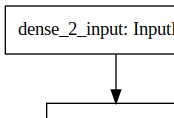

In [79]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [80]:
#compile : loss, optimizer, metrics 를 지정
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #mae를 이용해서 평가
#compile을 해주여야한다. (fit()에서 이중for문의 역할을 한다.)
#변수를 사용하지 않더라도 자동으로 호출되어서 진행된다.
model.fit(x_train, y_train, batch_size=1, epochs=10, verbose=1) #verbose=1 - 진행상황을 보여줘라 , verbose=False 결과만 보여줘라

Epoch 1/10
404/404 [==============================] - 1s 2ms/step - loss: 1629.4415 - mae: 31.2132
Epoch 2/10
404/404 [==============================] - 1s 1ms/step - loss: 303.4441 - mae: 13.3414
Epoch 3/10
404/404 [==============================] - 1s 1ms/step - loss: 175.8556 - mae: 10.2532
Epoch 4/10
404/404 [==============================] - 1s 1ms/step - loss: 139.5528 - mae: 9.0091
Epoch 5/10
404/404 [==============================] - 1s 1ms/step - loss: 122.5425 - mae: 8.3356
Epoch 6/10
404/404 [==============================] - 1s 1ms/step - loss: 109.1184 - mae: 7.6820
Epoch 7/10
404/404 [==============================] - 1s 1ms/step - loss: 97.0942 - mae: 7.1625
Epoch 8/10
404/404 [==============================] - 1s 1ms/step - loss: 90.3998 - mae: 6.6476
Epoch 9/10
404/404 [==============================] - 1s 1ms/step - loss: 82.7242 - mae: 6.4822
Epoch 10/10
404/404 [==============================] - 1s 1ms/step - loss: 77.7603 - mae: 6.2154


In [81]:
mse, mae = model.evaluate(x_test, y_test, verbose=False)
rmse = np.sqrt(mse)
mse, rmse, mae

(81.28032160740273, 9.015559971926466, 6.251389980316162)

In [82]:
pred = model.predict(x_test[:3,:])
pred

array([[ 2.1159942],
       [19.294737 ],
       [21.83674  ]], dtype=float32)

In [83]:
real = y_test[:3]
real

array([ 7.2, 18.8, 19. ])

In [86]:
import pandas as pd
dataset = pd.read_csv('iris.csv', header=None)
dataset.head()
dataset = dataset.iloc[1:,:]
print(dataset.shape)
dataset.head()

(150, 5)


,0,1,2,3,4
1,6.4,2.8,5.6,2.2,2
2,5.0,2.3,3.3,1,1
3,4.9,2.5,4.5,1.7,2
4,4.9,3.1,1.5,0.1,0
5,5.7,3.8,1.7,0.3,0


In [87]:
from keras.utils import np_utils
X = dataset.iloc[:,:4] #독립변수
Y = dataset.iloc[:,4] #종속변수
Y = np.asarray(Y)
Y = keras.utils.to_categorical(Y) #one hot encoding
print(X.shape)
print(Y.shape)

(150, 4)
(150, 3)


In [89]:
from keras.models import Sequential #input, utput 1개씩 존재
from keras.wrappers.scikit_learn import KerasClassifier #keras의 모델과 scikit의 모델의 호환성을 가진다.
from keras.layers import Dense #dense = ffnn망 fully connected망
from sklearn.model_selection import GridSearchCV #parameter를 grid를 만들고 best param을 찾는다.
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [92]:
model = Sequential() #입력은 자동으로 된다. (이전레이어의 출력값이 다음레이어의 입력값으로 들어간다.)
model.add(Dense(15, input_dim=4, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
#categorical_crossentropy - 분류문제를 다루는 크로스 엔트로피 , 확률을 불순도로 변경해서 최적화의 대상(cost function)이 되도록한다.
#adam 
    #adagrad(처음에는 크게 점점작게, 0이되는것을 방지하기 위해 ada delta등장) -> RMSProp(상태를 보면서 러닝레이트를 줄인다.)
    # + momentum
#metrics 는 여러값을 넣을수 있으니 list자료형으ㅊ로 받는다.
model.fit(X,Y,epochs=100, batch_size=10, validation_split=0.3) #7:3으로 데이터를 나눠라 -> train / validation(과적합을 확인하기 위해)
#X의 차수 150*4 , 가중치 사이스 4*15, 나가는 데이터 150*15

Train on 105 samples, validate on 45 samples
Epoch 1/100
105/105 [==============================] - 0s 3ms/step - loss: 1.9257 - accuracy: 0.3810 - val_loss: 2.3821 - val_accuracy: 0.2222
Epoch 2/100
105/105 [==============================] - 0s 272us/step - loss: 1.7294 - accuracy: 0.4095 - val_loss: 2.1207 - val_accuracy: 0.5333
Epoch 3/100
105/105 [==============================] - 0s 266us/step - loss: 1.5515 - accuracy: 0.6762 - val_loss: 1.8655 - val_accuracy: 0.5556
Epoch 4/100
105/105 [==============================] - 0s 256us/step - loss: 1.3678 - accuracy: 0.7048 - val_loss: 1.6280 - val_accuracy: 0.5778
Epoch 5/100
105/105 [==============================] - 0s 256us/step - loss: 1.1931 - accuracy: 0.7048 - val_loss: 1.3973 - val_accuracy: 0.5778
Epoch 6/100
105/105 [==============================] - 0s 254us/step - loss: 1.0344 - accuracy: 0.7048 - val_loss: 1.1821 - val_accuracy: 0.5778
Epoch 7/100
105/105 [==============================] - 0s 277us/step - loss: 0.8957 - a

Epoch 57/100
105/105 [==============================] - 0s 287us/step - loss: 0.3158 - accuracy: 0.9524 - val_loss: 0.3227 - val_accuracy: 0.9778
Epoch 58/100
105/105 [==============================] - 0s 257us/step - loss: 0.3117 - accuracy: 0.9524 - val_loss: 0.3125 - val_accuracy: 0.9778
Epoch 59/100
105/105 [==============================] - 0s 268us/step - loss: 0.3095 - accuracy: 0.9524 - val_loss: 0.3086 - val_accuracy: 0.9778
Epoch 60/100
105/105 [==============================] - 0s 273us/step - loss: 0.3064 - accuracy: 0.9524 - val_loss: 0.3076 - val_accuracy: 0.9778
Epoch 61/100
105/105 [==============================] - 0s 270us/step - loss: 0.3054 - accuracy: 0.9333 - val_loss: 0.3197 - val_accuracy: 0.9333
Epoch 62/100
105/105 [==============================] - 0s 267us/step - loss: 0.3037 - accuracy: 0.9429 - val_loss: 0.2979 - val_accuracy: 0.9778
Epoch 63/100
105/105 [==============================] - 0s 427us/step - loss: 0.2971 - accuracy: 0.9524 - val_loss: 0.3011 -

In [116]:
def baseline_model():
    #model을 하나의 함수에 담았다.
    model = Sequential()
    model.add(Dense(8, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [117]:
#keras쪽 모델을 함수화 해서 받는다.
model = KerasClassifier(build_fn = baseline_model, verbose=1) #build_fn 작성한 model function을 담는 매개변수
batch_size=[10,20,30]
epochs=[10,50,100] #3*3으로 9개의 조합으로 구성되어진다.
param_grid=dict(batch_size=batch_size, epochs=epochs)
grid=GridSearchCV(model, param_grid=param_grid, n_jobs=-1) #GridSearchCV에 함수모델을 내포한 model 을 넣을 수 있게된다.
grid_result=grid.fit(X,Y)
print('최적스코어 : {:.4f} 사용한 파라미터 조합 : {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    #스코어별로 파라미터 조합을 볼 수 있다.
    print('{:.2f} ({:.2f}) with{}'.format(mean, std, param))

Epoch 1/100
150/150 [==============================] - 0s 2ms/step - loss: 1.0990 - accuracy: 0.2667
Epoch 2/100
150/150 [==============================] - 0s 199us/step - loss: 1.0987 - accuracy: 0.2667
Epoch 3/100
150/150 [==============================] - 0s 186us/step - loss: 1.0987 - accuracy: 0.3067
Epoch 4/100
150/150 [==============================] - 0s 185us/step - loss: 1.0987 - accuracy: 0.3000
Epoch 5/100
150/150 [==============================] - 0s 186us/step - loss: 1.0987 - accuracy: 0.3133
Epoch 6/100
150/150 [==============================] - 0s 192us/step - loss: 1.0987 - accuracy: 0.3000
Epoch 7/100
150/150 [==============================] - 0s 186us/step - loss: 1.0987 - accuracy: 0.3000
Epoch 8/100
150/150 [==============================] - 0s 193us/step - loss: 1.0987 - accuracy: 0.3133
Epoch 9/100
150/150 [==============================] - 0s 187us/step - loss: 1.0987 - accuracy: 0.3067
Epoch 10/100
150/150 [==============================] - 0s 173us/step - los

150/150 [==============================] - 0s 306us/step - loss: 1.0987 - accuracy: 0.2933
Epoch 80/100
150/150 [==============================] - 0s 305us/step - loss: 1.0987 - accuracy: 0.2867
Epoch 81/100
150/150 [==============================] - 0s 306us/step - loss: 1.0987 - accuracy: 0.2800
Epoch 82/100
150/150 [==============================] - 0s 306us/step - loss: 1.0986 - accuracy: 0.3333
Epoch 83/100
150/150 [==============================] - 0s 239us/step - loss: 1.0987 - accuracy: 0.2733
Epoch 84/100
150/150 [==============================] - 0s 173us/step - loss: 1.0986 - accuracy: 0.3333
Epoch 85/100
150/150 [==============================] - 0s 172us/step - loss: 1.0987 - accuracy: 0.2600
Epoch 86/100
150/150 [==============================] - 0s 173us/step - loss: 1.0986 - accuracy: 0.3333
Epoch 87/100
150/150 [==============================] - 0s 181us/step - loss: 1.0987 - accuracy: 0.3000
Epoch 88/100
150/150 [==============================] - 0s 174us/step - loss:

In [121]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('MinMax', MinMaxScaler()))
estimators.append(('classifier', KerasClassifier(build_fn=baseline_model, verbose=1))) #pipe라인 안에 KerasClassifier가 들어가있다.
pipeline = Pipeline(estimators)
param_grid = {'classifier__batch_size':batch_size, 'classifier__epochs':epochs} #pipeline과 gridSearchCV를 결합했을때
#키의 매개변수에 접근하는 방식은 : 키이름__매개변수이름을 넣게된다.
grid = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X,Y)
print('최적스코어 : {:.4f} , 사용한 파라메터 조합 : {}'.format(grid_result.best_score_, grid_result.best_params_))

Epoch 1/100
150/150 [==============================] - 0s 2ms/step - loss: 1.0864 - accuracy: 0.3400
Epoch 2/100
150/150 [==============================] - 0s 206us/step - loss: 1.0741 - accuracy: 0.3533
Epoch 3/100
150/150 [==============================] - 0s 199us/step - loss: 1.0643 - accuracy: 0.3733
Epoch 4/100
150/150 [==============================] - 0s 212us/step - loss: 1.0539 - accuracy: 0.5000
Epoch 5/100
150/150 [==============================] - 0s 245us/step - loss: 1.0436 - accuracy: 0.5867
Epoch 6/100
150/150 [==============================] - 0s 222us/step - loss: 1.0327 - accuracy: 0.6000
Epoch 7/100
150/150 [==============================] - 0s 220us/step - loss: 1.0219 - accuracy: 0.6067
Epoch 8/100
150/150 [==============================] - 0s 246us/step - loss: 1.0107 - accuracy: 0.6333
Epoch 9/100
150/150 [==============================] - 0s 221us/step - loss: 0.9994 - accuracy: 0.6467
Epoch 10/100
150/150 [==============================] - 0s 236us/step - los

150/150 [==============================] - 0s 206us/step - loss: 0.5815 - accuracy: 0.6933
Epoch 80/100
150/150 [==============================] - 0s 166us/step - loss: 0.5786 - accuracy: 0.6933
Epoch 81/100
150/150 [==============================] - 0s 140us/step - loss: 0.5758 - accuracy: 0.6933
Epoch 82/100
150/150 [==============================] - 0s 140us/step - loss: 0.5736 - accuracy: 0.7000
Epoch 83/100
150/150 [==============================] - 0s 153us/step - loss: 0.5707 - accuracy: 0.7000
Epoch 84/100
150/150 [==============================] - 0s 199us/step - loss: 0.5681 - accuracy: 0.7000
Epoch 85/100
150/150 [==============================] - 0s 196us/step - loss: 0.5657 - accuracy: 0.7000
Epoch 86/100
150/150 [==============================] - 0s 286us/step - loss: 0.5632 - accuracy: 0.7067
Epoch 87/100
150/150 [==============================] - 0s 360us/step - loss: 0.5610 - accuracy: 0.7067
Epoch 88/100
150/150 [==============================] - 0s 366us/step - loss:

In [118]:
#문제
    # optimizer를 튜닝하시오 (어떤 놈이 좋은지) : Adam, RMSprop, SGD, Adagrad

In [137]:
def baseline_model(optimizer='adam'):
    #model을 하나의 함수에 담았다.
    model = Sequential()
    model.add(Dense(8, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [141]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
estimators = []
epochs = [10,50,100]
batches = [10,20,30]
optimizers = ['rmsprop', 'adam', 'SGD']

estimators.append(('MinMax', MinMaxScaler()))
estimators.append(('classifier', KerasClassifier(build_fn=baseline_model, verbose=1)))
pipeline = Pipeline(estimators)
param_grid = {'classifier__batch_size':batches, 'classifier__epochs':epochs, 'classifier__optimizer':optimizers} 

grid = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X,Y)
print('최적스코어 : {:.4f} , 사용한 파라메터 조합 : {}'.format(grid_result.best_score_, grid_result.best_params_))

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 1.0983 - accuracy: 0.1000
Epoch 2/100
150/150 [==============================] - 0s 326us/step - loss: 1.0961 - accuracy: 0.2600
Epoch 3/100
150/150 [==============================] - 0s 306us/step - loss: 1.0893 - accuracy: 0.3800
Epoch 4/100
150/150 [==============================] - 0s 306us/step - loss: 1.0837 - accuracy: 0.3800
Epoch 5/100
150/150 [==============================] - 0s 300us/step - loss: 1.0787 - accuracy: 0.3333
Epoch 6/100
150/150 [==============================] - 0s 319us/step - loss: 1.0730 - accuracy: 0.3800
Epoch 7/100
150/150 [==============================] - 0s 326us/step - loss: 1.0672 - accuracy: 0.4933
Epoch 8/100
150/150 [==============================] - 0s 326us/step - loss: 1.0606 - accuracy: 0.5867
Epoch 9/100
150/150 [==============================] - 0s 300us/step - loss: 1.0537 - accuracy: 0.6533
Epoch 10/100
150/150 [==============================] - 0s 300us/step - los

150/150 [==============================] - 0s 549us/step - loss: 0.3970 - accuracy: 0.9600
Epoch 80/100
150/150 [==============================] - 0s 366us/step - loss: 0.3929 - accuracy: 0.9600
Epoch 81/100
150/150 [==============================] - 0s 545us/step - loss: 0.3896 - accuracy: 0.9400
Epoch 82/100
150/150 [==============================] - 0s 351us/step - loss: 0.3852 - accuracy: 0.9467
Epoch 83/100
150/150 [==============================] - 0s 348us/step - loss: 0.3820 - accuracy: 0.9600
Epoch 84/100
150/150 [==============================] - 0s 551us/step - loss: 0.3780 - accuracy: 0.9600
Epoch 85/100
150/150 [==============================] - 0s 552us/step - loss: 0.3743 - accuracy: 0.9600
Epoch 86/100
150/150 [==============================] - 0s 605us/step - loss: 0.3716 - accuracy: 0.9533
Epoch 87/100
150/150 [==============================] - 0s 612us/step - loss: 0.3687 - accuracy: 0.9600
Epoch 88/100
150/150 [==============================] - 0s 582us/step - loss:

In [133]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

estimators = KerasClassifier(build_fn=baseline_model, verbose=1)

epochs = [10,50,100]
batches = [10,20,30]
optimizers = ['rmsprop', 'adam', 'SGD']
params = dict(epochs=epochs, batch_size=batches, optimizer=optimizers)

grid = GridSearchCV(estimator=estimators, param_grid=params, n_jobs=-1)
grid_result = grid.fit(X,Y)
print('최적스코어 : {:.4f} , 사용한 파라메터 조합 : {}'.format(grid_result.best_score_, grid_result.best_params_))

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/100
150/150 [==============================] - 1s 4ms/step - loss: 1.1127 - accuracy: 0.2800
Epoch 2/100
150/150 [==============================] - 0s 279us/step - loss: 1.0926 - accuracy: 0.2533
Epoch 3/100
150/150 [==============================] - 0s 387us/step - loss: 1.0814 - accuracy: 0.2800
Epoch 4/100
150/150 [==============================] - 0s 326us/step - loss: 1.0709 - accuracy: 0.2733
Epoch 5/100
150/150 [==============================] - 0s 330us/step - loss: 1.0595 - accuracy: 0.3267
Epoch 6/100
150/150 [==============================] - 0s 308us/step - loss: 1.0477 - accuracy: 0.3933
Epoch 7/100
150/150 [==============================] - 0s 339us/step - loss: 1.0370 - accuracy: 0.6200
Epoch 8/100
150/150 [==============================] - 0s 321us/step - loss: 1.0258 - accuracy: 0.6133
Epoch 9/100
150/150 [==============================] - 0s 319us/step - loss: 1.0152 - accuracy: 0.6533
Epoch 10/100
150/150 [==============================] - 0s 287us/step - los

150/150 [==============================] - 0s 675us/step - loss: 0.4465 - accuracy: 0.6867
Epoch 80/100
150/150 [==============================] - 0s 642us/step - loss: 0.4453 - accuracy: 0.6733
Epoch 81/100
150/150 [==============================] - 0s 612us/step - loss: 0.4439 - accuracy: 0.7067
Epoch 82/100
150/150 [==============================] - 0s 610us/step - loss: 0.4409 - accuracy: 0.7000
Epoch 83/100
150/150 [==============================] - 0s 635us/step - loss: 0.4385 - accuracy: 0.6933
Epoch 84/100
150/150 [==============================] - 0s 633us/step - loss: 0.4368 - accuracy: 0.6933
Epoch 85/100
150/150 [==============================] - 0s 639us/step - loss: 0.4346 - accuracy: 0.7000
Epoch 86/100
150/150 [==============================] - 0s 609us/step - loss: 0.4329 - accuracy: 0.7067
Epoch 87/100
150/150 [==============================] - 0s 625us/step - loss: 0.4325 - accuracy: 0.7267
Epoch 88/100
150/150 [==============================] - 0s 618us/step - loss:

In [124]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

np.random.seed(0)

In [125]:
number_of_features = 100
features, target = make_classification(n_samples = 10000,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

In [126]:
def create_network(optimizer='rmsprop'):
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation='relu', input_shape=(number_of_features,)))
    network.add(layers.Dense(units=16, activation='relu'))
    network.add(layers.Dense(units=1, activation='sigmoid'))
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer=optimizer, # Optimizer
                    metrics=['accuracy']) # Accuracy performance metric
    return network


In [127]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, verbose=0)

In [128]:
epochs = [5, 10]
batches = [5, 10, 100]
optimizers = ['rmsprop', 'adam']

hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)

In [129]:
grid = GridSearchCV(estimator=neural_network, cv=3, param_grid=hyperparameters)

grid_result = grid.fit(features, target)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [130]:
grid_result.best_params_

{'batch_size': 10, 'epochs': 5, 'optimizer': 'adam'}